# <a id='toc1_'></a>[Calculating data center emissions](#toc0_)


**Note**: This project uses [IBM Environmental Intelligence APIs](https://www.ibm.com/products/environmental-intelligence/?utm_source=skills_network&utm_content=in_lab_content_link&utm_id=Lab-Calculating+data+center+emissions-v1_1730177557), specifically the [GHG Emissions APIs](https://developer.ibm.com/apis/catalog/envintelsuite--ibm-environmental-intelligence/GHG+Emissions+API#overview), to walk step by step through the [Calculating data center emissions](https://github.com/IBM/Environmental-Intelligence/blob/main/ghg_emissions/samples/scope2/datacenter_emission_capture/datacenter_emission_capture.ipynb) use case.


**Table of contents**<a id='toc0_'></a>    
- [Calculating data center emissions](#toc1_)    
  - [Introduction](#toc1_1_)    
  - [What does this project do?](#toc1_2_)    
  - [Objectives](#toc1_3_)    
  - [Setup](#toc1_4_)    
    - [Installing required libraries](#toc1_4_1_)    
  - [GHG emissions APIs](#toc1_5_)    
  - [Download the data](#toc1_6_)    
  - [Utility functions](#toc1_7_)    
    - [Function to call API](#toc1_7_1_)    
    - [Input format for API](#toc1_7_2_)    
    - [Accepted input values](#toc1_7_3_)    
  - [Use case implementation](#toc1_8_)    
    - [Read sample data from the data center](#toc1_8_1_)    
    - [Data center locations](#toc1_8_2_)    
    - [Data center carbon footprints: Location-based API](#toc1_8_3_)    
      - [Data center: Location-based carbon footprints distribution](#toc1_8_3_1_)    
      - [Output explanation](#toc1_8_3_2_)    
    - [Data center carbon footprints: Market-based API](#toc1_8_4_)    
      - [Data center: Market-based carbon footprints distribution](#toc1_8_4_1_)    
      - [Output explanation](#toc1_8_4_2_)    
    - [Comparison of location-based and market-based carbon intensity](#toc1_8_5_)    
  - [Interested to learn more?](#toc1_9_)     


## <a id='toc1_1_'></a>[Introduction](#toc0_)

By using the **GHG Emissions APIs**, you can calculate internal carbon emissions and supply chain emissions.

The APIs that are listed in Table 1 are provided with Carbon Performance Engine application in **IBM Environmental Intelligence**.

Carbon Performance Engine calculates several types of emissions for an organization, including the emission that fall under the following scope categories as defined by the GHG protocol:

- Scope 1: **Direct greenhouse gas (GHG) emissions** that can be directly controlled by an organization. The source of the emissions comes from sources that are owned by the organization, for example, fossil fuel.
- Scope 2: **Indirect GHG emissions** that can be indirectly controlled by an organization, such as the purchase of electricity.
- Scope 3: **Indirect GHG emissions** from upstream or downstream in the value chain of a company, for example, business travel or transportation of goods.

**Table 1**: API endpoints Emission type

| **Endpoint** | **Scope level** | **Description** |
| --- | --- | --- |
| Stationary endpoint POST carbon/stationary | 1 | Calculate emissions from comfort heating or combustion of fuels in stationary combustion sources. |
| Fugitive endpoint POST /carbon/fugitive | 1 | Calculate emissions from leaks of greenhouse gasses (GHG) from refrigeration or air conditioning units. |
| Location endpoint POST /carbon/location | 2 | Calculate emissions from electricity grids that are providing an organization with energy. |
| Market endpoint POST /carbon/market | 2 | Calculate emission hotspots in the supply chain from resources and entry risks in the chain. |
| Transport endpoint POST /carbon/transportation_and_distribution | 3 | Calculate emissions from business-related employee travel, employee commuting, and freight transport. |



GHG Emission APIs that are used in this sample: **IBM Environmental Intelligence - Greenhouse Gas (GHG) Emissions - Location and Market APIs**

You can calculate Scope 2 emissions from data centers. The Location and Market APIs provide the necessary emission factors to automate the process of calculating greenhouse gas emissions associated with electricity, steam, heat, and cooling workloads.




## <a id='toc1_2_'></a>[What does this project do?](#toc0_)

This use case demonstrates that by understanding the data center emissions using the **GHG Location and Market API**, data center operators can assess their environmental impact for reporting and identify opportunities for emissions reduction.



## <a id='toc1_3_'></a>[Objectives](#toc0_)

After completing this lab, you will be able to:

- Understand how to set up and configure **IBM Environmental Intelligence - Greenhouse Gas (GHG) Emissions - Location and Market APIs**.
- Learn to use **Location and Market APIs**.


## <a id='toc1_4_'></a>[Setup](#toc0_)

For this lab, we will be using the following libraries:


*   [`pandas`](https://pandas.pydata.org/): pandas is a fast, powerful, flexible and easy to use open source data analysis and data manipulation library built on top of the Python programming language.
*   [`requests`](https://pypi.org/project/requests/): Requests is an elegant and simple HTTP library for Python.
*   [`json`](https://docs.python.org/3/library/json.html): JSON (JavaScript Object Notation) is a lightweight data-interchange format.
*   [`plotly`](https://plotly.com/python/): Plotly is a Python graphing library that makes interactive, publication-quality graphs online.
*   [`kaleido`](https://pypi.org/project/kaleido/): Kaleido is a Python library that enables users to convert Plotly figures to static images.
*   [`nbformat`](https://pypi.org/project/nbformat/): The Jupyter Notebook format.
*   [`matplotlib`](https://matplotlib.org/) for additional plotting tools.
*   [`IPython`](https://pypi.org/project/ipython/): IPython provides a rich architecture for interactive computing with:
    - A powerful interactive shell.
    - A kernel for Jupyter.
    - Support for interactive data visualization.


In [15]:
%%capture
%pip install pandas==2.1.4 --no-warn-script-location | tail -n 1
%pip install geopy==2.4.1 --no-warn-script-location | tail -n 1
%pip install plotly==5.24.1 --no-warn-script-location --user | tail -n 1
%pip install kaleido==0.2.1 --no-warn-script-location | tail -n 1
%pip install nbformat==5.10.4 --no-warn-script-location | tail -n 1

In [1]:
#All imports needed for the sample
import pandas as pd
import requests
import json
from IPython.display import display as display_summary
import plotly.express as px
from plotly.offline import init_notebook_mode
from plotly.offline import iplot
from datetime import datetime
import plotly.graph_objects as go

import warnings
warnings.filterwarnings('ignore')

## <a id='toc1_5_'></a>[Accessing GHG emissions APIs](#toc0_)

This section provides the steps for you to obtain the necessary credentials to access the Environmental Intelligence APIs. Once you have signed up, you will receive the `api_key`, `tenant_id`, and `org_id` that you need to access the APIs.

**Note**: The following steps are intended for new registrants only. If you previously created an IBMid, go to the Free APIs Preview [sign-up form](https://www.ibm.com/account/reg/us-en/signup?utm_source=skills_network&utm_content=in_lab_content_link&utm_id=Lab-Calculating+data+center+emissions-v1&formid=urx-52894), click **Log in**, and go to step 3 below, starting at “A page opens ….”

1. Go to the Free APIs Preview [sign-up form](https://www.ibm.com/account/reg/us-en/signup?utm_source=skills_network&utm_content=in_lab_content_link&utm_id=Lab-Calculating+data+center+emissions-v1&formid=urx-52894).
2. Complete the form and click **Next**. A message displays stating that a verification code has been sent to the email address you entered. (If you don't see the email with the code, be sure to check your Spam or Promotions folder.)
3. Enter the validation code from the email and click **Submit**. A page opens indicating that your request has been received and that you will receive an email when your access is ready. That email will include a link to the Developer Console, Samples, and Learning Courses. (If you don't see the email, check your Spam or Promotions folder.)
4. After you login to the Developer Console using your IBMid, you will have access to your **API key**, **OrgId**, **TenantId (ClientId)**, and token.
5. Use the **API key**, **OrgId**, and **TenantId** to access and use the APIs.


**Note**: If you see a 401 Unauthorized error:
- Check the Authorization.
- Re-enter the security parameters in the correct order if missing.



In [2]:
# Copy your keys here
EI_API_KEY    = '/'

EI_CLIENT_ID = 'ibm-agro-api'
EI_AUTH_ENPOINT = 'https://auth-b2b-twc.ibm.com/Auth/GetBearerForClient'
EI_BASE_URL = 'https://foundation.agtech.ibm.com'

def get_bearer_token(token):
    headers = {
        'Content-Type': 'application/json',
        'cache-control': 'no-cache',
    }
    data = {"apiKey":token, "clientId":EI_CLIENT_ID}
    bearer_token_req = requests.post(EI_AUTH_ENPOINT, headers=headers, data= json.dumps(data))
    if bearer_token_req.status_code != 200:
        print( "Error in getting Bearer token. Error code : ",bearer_token_req.status_code)
    else:
        print("Bearer token generated")
    return bearer_token_req.json()['access_token']

mybearer_token = get_bearer_token(EI_API_KEY)

Bearer token generated


## <a id='toc1_6_'></a>[Download the data](#toc0_)


In [3]:
import os
import requests


# Define the URL and the local file name
url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/99AYlOgshB8AoCPs7GLTxQ/datacenter-emission-capture.csv'
local_filename = 'datacenter_emission_capture.csv'

# Check if the file exists
if os.path.exists(local_filename):
    print(f"{local_filename} already exists, overwriting...")

# Download the file from `url` and save it locally
with requests.get(url, stream=True) as r:
    r.raise_for_status()
    with open(local_filename, 'wb') as f:
        for chunk in r.iter_content(chunk_size=8192): 
            f.write(chunk)

print(f"Downloaded {local_filename} successfully.")

Downloaded datacenter_emission_capture.csv successfully.


## <a id='toc1_7_'></a>[Utility functions](#toc0_)

Let us setup utility helper functions to run this use case.

### <a id='toc1_7_1_'></a>[Function to call API](#toc0_)



In [4]:
def Call_Carbon_API(CO2API, Co2Data, token):
    headers = {
        'accept': 'application/json',
        'Authorization': 'Bearer '+token,
        'Content-Type': 'application/json',
    }

    CO2response_req = requests.post( CO2API, headers=headers, data=json.dumps(Co2Data))
    if CO2response_req.status_code != 200:
        print( "Problem! Error in generating response. Error code : ",CO2response_req.status_code)
    return CO2response_req.json()


### <a id='toc1_7_2_'></a>[Input format for API](#toc0_)


In [5]:
def customer_id(customerid):
    Input =  {
              "id": customerid
          }
    return Input 

def customer_onBehalfOfClient(companyId,companyName):
    Input =  {
              "companyId": companyId,
              "companyName": companyName
          }
    return Input  


def customer_organisation(departmentId,departmentName):
    Input =  {
              "departmentId": departmentId,
              "departmentName": departmentName
          }
    return Input  


def customer_requestType(requestType):
    Input =  {
              "requestType": requestType,
             }
    return Input     


def customer_location(country,stateProvince,zipPostCode,city):
    Input =  {
              "country": country,
              "stateProvince": stateProvince,
              "zipPostCode": zipPostCode,
              "city": city
          }
    return Input        


def customer_site(siteId,siteName,buildingId,buildingName):
    Input = {
              "siteId": siteId,
              "siteName": siteName,
              "buildingId": buildingId,
              "buildingName": buildingName
          }               
    return Input

def location_input(commodity,energyConsumedMWh):
    input = {"commodity": commodity,
             "energyConsumedMWh": energyConsumedMWh
             }
    return input

def market_input(commodity,energyConsumedMWh,energySupplierResidualEF,supplierNameREC,energyPurchasedMWhREC,emissionFactorREC,
                sourceREC,expiryDateREC,instrumentTypeREC,trackingSystemREC,certificateNumberREC,supplierNameREDI,
                energyPurchasedMWhREDI,emissionFactorREDI,sourceREDI,expiryDateREDI,certificateNumberREDI,
                supplierNameDEPC,energyPurchasedMWhDEPC, suppliedEmissionFactorDEPC,expiryDateDEPC,certificateNumberDEPC):
    input = {"commodity": commodity,
             "energyConsumedMWh": energyConsumedMWh,
             "energySupplierResidualEF": energySupplierResidualEF,
             "supplierNameREC": supplierNameREC,
             "energyPurchasedMWhREC":energyPurchasedMWhREC,
             "emissionFactorREC":emissionFactorREC,
             "sourceREC": sourceREC,
             "expiryDateREC": expiryDateREC,
             "instrumentTypeREC": instrumentTypeREC,
             "trackingSystemREC": trackingSystemREC,
             "certificateNumberREC": certificateNumberREC,
             "supplierNameREDI": supplierNameREDI,
             "energyPurchasedMWhREDI": energyPurchasedMWhREDI,
             "emissionFactorREDI": emissionFactorREDI,
             "sourceREDI": sourceREDI,
             "expiryDateREDI": expiryDateREDI,
             "certificateNumberREDI": certificateNumberREDI,
             "supplierNameDEPC": supplierNameDEPC,
             "energyPurchasedMWhDEPC": energyPurchasedMWhDEPC,
             "suppliedEmissionFactorDEPC": suppliedEmissionFactorDEPC,
             "expiryDateDEPC": expiryDateDEPC,
             "certificateNumberDEPC": certificateNumberDEPC
  }
    return input

### <a id='toc1_7_3_'></a>[Accepted input values](#toc0_)



You can check the accepted values for the individual fields of the request payload. For more information, see the [Market section of the GHG Emissions API Developer Guide](https://developer.ibm.com/apis/catalog/envintelsuite--ibm-environmental-intelligence/GHG+Emissions+API#market) and the [Location section of the GHG Emissions Developer Guide](https://developer.ibm.com/apis/catalog/envintelsuite--ibm-environmental-intelligence/GHG+Emissions+API#location).



## <a id='toc1_8_'></a>[Use case implementation](#toc0_)

### <a id='toc1_8_1_'></a>[Read sample data from the data center](#toc0_)




In [6]:
df_asset = pd.read_csv("./datacenter_emission_capture.csv")
df_asset.head(5)

,Latitude,Longitude,Start Date (YYYY-MM-DD),End Date (YYYY-MM-DD),Commodity Usage,IT Load,PUE,Total Consumption,Renewable,Non-Renewable,Consumption Unit,Country,State,City,Zip Code,REDI Expiry Date,REDI Supplier Name,REDI Energy Source,REDI Certificate Number
0,40.7128,-74.0060,2022-01-01,2022-12-31,Electricity,70000,4.3,301000,60200,240800,MWh,USA,New York,New York,10001,2022-12-31,Bright Solar Solutions,Solar,RE12345
1,34.0522,-118.2437,2022-01-01,2022-12-31,Electricity,520300,3.5,1821050,0,1821050,MWh,USA,California,Los Angeles,90001,NaN,NaN,NaN,NaN
2,41.8781,-87.6298,2022-01-01,2022-12-31,Electricity,1200000,1.8,2160000,2160000,0,MWh,USA,Illinois,Chicago,60601,2022-12-31,SunRise Energy,Solar,RE12347
3,29.7604,-95.3698,2022-01-01,2022-12-31,Electricity,3000000,1.4,4200000,1806000,2394000,MWh,USA,Texas,Houston,77001,2022-12-31,GreenWind Energy,Wind,RE12348
4,33.4484,-112.0740,2022-01-01,2022-12-31,Electricity,800000,2.5,2000000,100000,1900000,MWh,USA,Arizona,Phoenix,85001,2022-12-31,SolarCity Renewables,Solar,RE12349


### <a id='toc1_8_2_'></a>[Data center locations](#toc0_)


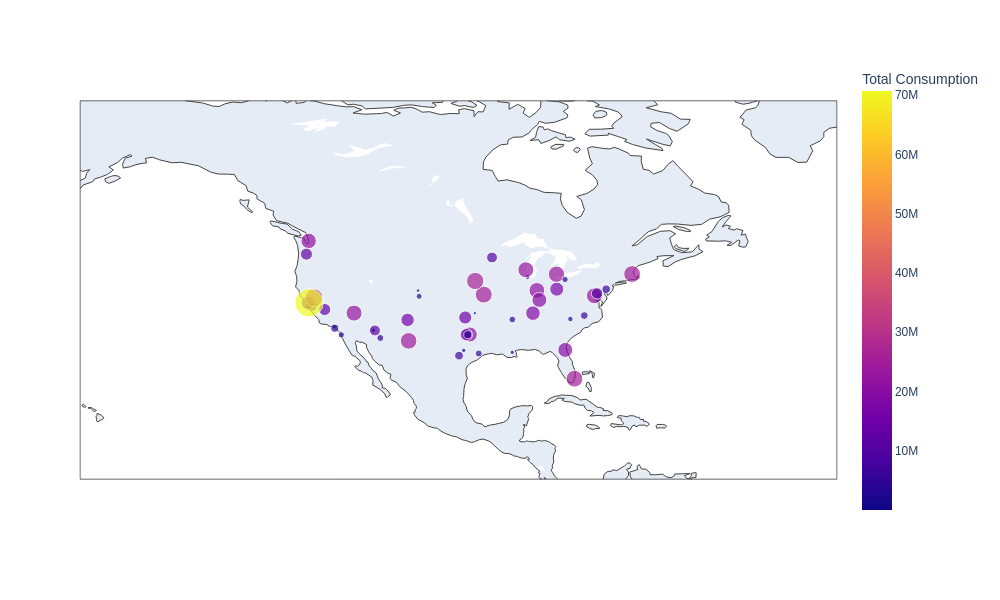

In [7]:
init_notebook_mode (connected = True)
fig = px.scatter_geo(df_asset, lat="Latitude",lon="Longitude",color="Total Consumption",hover_name="City", hover_data={'Renewable':True,'Non-Renewable':True}, size='Total Consumption')
fig.update_geos(
    center={"lat": 39.8283, "lon": -98.5795},  # Center of the USA
    projection_scale=3  # Zoom level (lower values zoom in more)
)
fig.update_layout(width=1000, 
    height=600 )
# fig.show()
fig.show("png")

### <a id='toc1_8_3_'></a>[Data center carbon footprints: Location-based API](#toc0_)

Calculating data center carbon footprints based on the location.


In [8]:
EI_location_API_ENDPOINT = f"{EI_BASE_URL}/v2/carbon/location"
CO2Response_list = []
for _,row in df_asset.iterrows():
    request_payload ={'customID'        : customer_id(customerid='Retailer_A_mobile_31234'), 
                    'onBehalfOfClient': customer_onBehalfOfClient(companyId='877889877',
                                                                    companyName='Retailer_A') , 
                    'organisation'    : customer_organisation(departmentId='384834',
                                                                departmentName='Acme_retail'), 
                    'requestType'     : customer_requestType(requestType='ACTUAL'), 
                    'location'        : customer_location(country=row['Country'],
                                                            stateProvince=row['State'],
                                                            zipPostCode=row['Zip Code'],
                                                            city=row['City']),
                    'site'            : customer_site(siteId='T2383823',
                                                        siteName='Retailed_A_South_Bank',
                                                        buildingId='B38383',
                                                        buildingName='Building_6'), 
                    'timePeriod'      : {'year' : pd.to_datetime(row['End Date (YYYY-MM-DD)']).year, 
                                            },
                    'activityData' : location_input(commodity=row['Commodity Usage'],
                                                        energyConsumedMWh=row['Total Consumption'])
                    }        

    CO2Response = Call_Carbon_API(EI_location_API_ENDPOINT , request_payload, mybearer_token)
    CO2Response_list.append(CO2Response)
df_location_res = pd.json_normalize(CO2Response_list)
df_asset ['loc_CO2e'] = df_location_res['CO2e (metric tonne)']

#### <a id='toc1_8_3_1_'></a>[Data center: Location-based carbon footprints distribution](#toc0_)


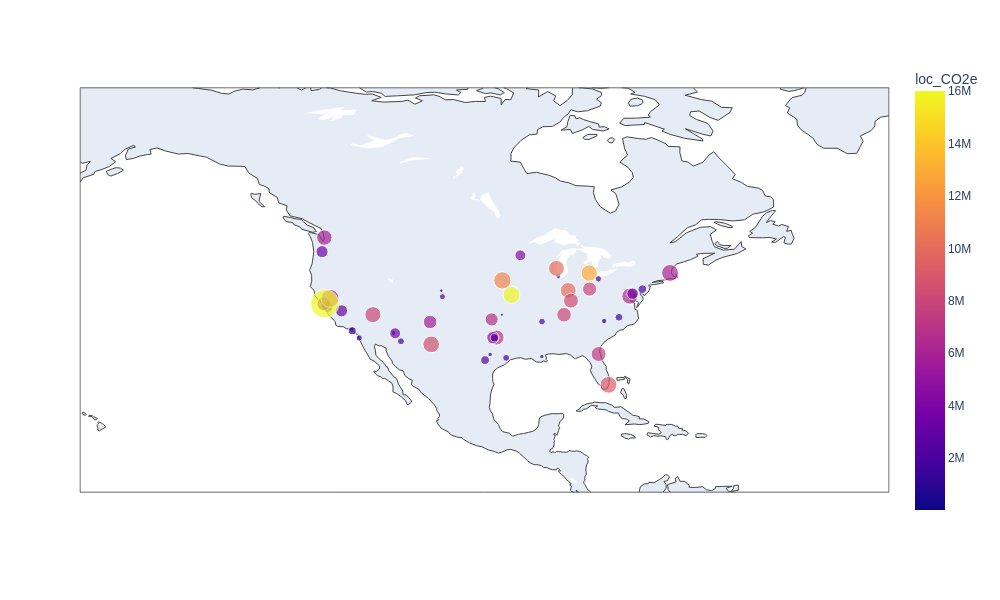

In [9]:
init_notebook_mode (connected = True)
fig = px.scatter_geo(df_asset, lat="Latitude",lon="Longitude",color="loc_CO2e",hover_name="City", hover_data={'Renewable':True,'Non-Renewable':True}, size='Total Consumption')
fig.update_geos(
    center={"lat": 39.8283, "lon": -98.5795},  # Center of the USA
    projection_scale=3  # Zoom level (lower values zoom in more)
)
fig.update_layout(width=1000, 
    height=600 )
# fig.show()
fig.show("png")

#### <a id='toc1_8_3_2_'></a>[Output explanation](#toc0_)



**CO2e (metric tonne)** - The total amount of greenhouse gases emitted in metric tonnes.

### <a id='toc1_8_4_'></a>[Data center carbon footprints: Market-based API](#toc0_)

Calculating data center carbon footprints based on the market.


In [10]:
# function to convert date to "%m-%d-%Y" format if not 'nan'
def convert_date(date_string):
    if pd.notna(date_string):
        date_object = datetime.strptime(date_string, "%Y-%m-%d")
        return date_object.strftime("%m-%d-%Y")
    else:
        return date_string  # Return 'nan' or whatever value it is

# function to return 'na' if not 'nan' (not a valid value)
def check_nan(value):
    if pd.notna(value):
        return value
    else:
        return 'na'
    
EI_market_API_ENDPOINT = f"{EI_BASE_URL}/v2/carbon/market"
CO2Response_list = []
for _,row in df_asset.iterrows():
    request_payload ={'customID'        : customer_id(customerid='Retailer_A_mobile_31234'), 
                    'onBehalfOfClient': customer_onBehalfOfClient(companyId='877889877',
                                                                    companyName='Retailer_A') , 
                    'organisation'    : customer_organisation(departmentId='384834',
                                                                departmentName='Acme_retail'), 
                    'requestType'     : customer_requestType(requestType='ACTUAL'), 
                    'location'        : customer_location(country=row['Country'],
                                                            stateProvince=row['State'],
                                                            zipPostCode=row['Zip Code'],
                                                            city=row['City']),
                    'site'            : customer_site(siteId='T2383823',
                                                        siteName='Retailed_A_South_Bank',
                                                        buildingId='B38383',
                                                        buildingName='Building_6'), 
                    'timePeriod'      : {'year' : pd.to_datetime(row['End Date (YYYY-MM-DD)']).year, 
                                            },
                    'activityData'   :  market_input(commodity=row['Commodity Usage'],
                                                    energyConsumedMWh=row['Total Consumption'],
                                                    energySupplierResidualEF='na',
                                                    supplierNameREC='na',
                                                    energyPurchasedMWhREC='na',
                                                    emissionFactorREC='na',
                                                    sourceREC='na',
                                                    expiryDateREC='na',
                                                    instrumentTypeREC='na',
                                                    trackingSystemREC='na',
                                                    certificateNumberREC='na',
                                                    supplierNameREDI=check_nan(row['REDI Supplier Name']),
                                                    energyPurchasedMWhREDI=check_nan(row['Renewable']),
                                                    emissionFactorREDI='0',
                                                    sourceREDI=check_nan(row['REDI Energy Source']),
                                                    expiryDateREDI=convert_date(row['REDI Expiry Date']),
                                                    certificateNumberREDI=check_nan(row['REDI Certificate Number']),
                                                    supplierNameDEPC='na',
                                                    energyPurchasedMWhDEPC='na', 
                                                    suppliedEmissionFactorDEPC='na',
                                                    expiryDateDEPC='na',
                                                    certificateNumberDEPC='na')
                    }        

    CO2Response = Call_Carbon_API(EI_market_API_ENDPOINT , request_payload, mybearer_token)
    CO2Response_list.append(CO2Response)
df_market_res = pd.json_normalize(CO2Response_list)
df_asset ['market_CO2e'] = df_market_res['CO2e (metric tonne)']

#### <a id='toc1_8_4_1_'></a>[Data center: Market-based carbon footprints distribution](#toc0_)


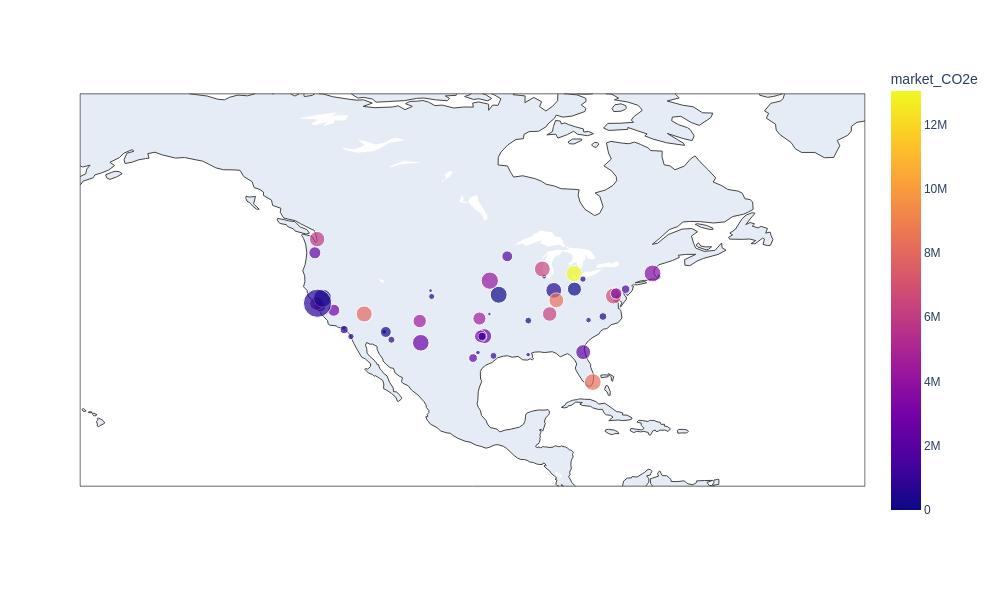

In [11]:
init_notebook_mode (connected = True)
fig = px.scatter_geo(df_asset, lat="Latitude",lon="Longitude",color="market_CO2e",hover_name="City", hover_data={'Renewable':True,'Non-Renewable':True}, size='Total Consumption')
fig.update_geos(
    center={"lat": 39.8283, "lon": -98.5795},  # Center of the USA
    projection_scale=3  # Zoom level (lower values zoom in more),
)
fig.update_layout(width=1000, 
    height=600 )
# fig.show()
fig.show("png")

#### <a id='toc1_8_4_2_'></a>[Output explanation](#toc0_)

CO2e (metric tonne) - The total amount of greenhouse gases emitted in metric tonnes.

### <a id='toc1_8_5_'></a>[Comparison of location-based and market-based carbon intensity](#toc0_)


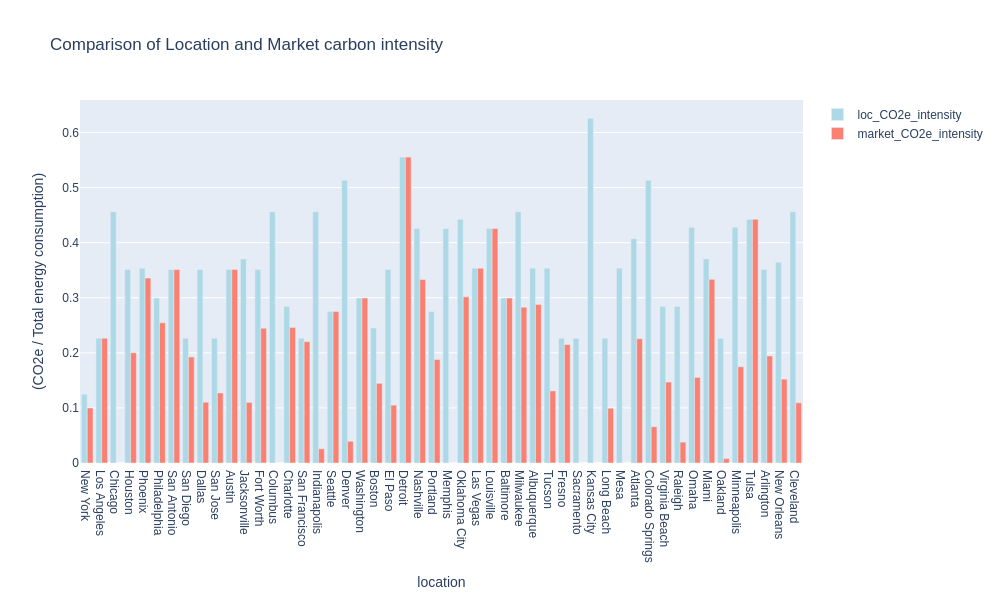

In [12]:
fig = go.Figure()
fig.add_trace(go.Bar(x=df_asset['City'], y=df_asset['loc_CO2e']/df_asset['Total Consumption'], name='loc_CO2e_intensity', marker_color='lightblue'))
fig.add_trace(go.Bar(x=df_asset['City'], y=df_asset['market_CO2e']/df_asset['Total Consumption'], name='market_CO2e_intensity', marker_color='salmon'))
fig.update_layout(
    title='Comparison of Location and Market carbon intensity ',
    xaxis_title='location',
    yaxis_title='(CO2e / Total energy consumption)',
    barmode='group',
    width=1000, 
    height=600 
)
fig.show("png")

Here, we see the carbon emission intensity of the location and market-based methods across 50 sample data centers. The location based emission considers only the average grid emission factor. The market based method also considers the purchase of renewables in accordance with GHG protocol. The variation in market based carbon intensity compared to location based across different locations shows the extra effort made by the enterprises to reduce the carbon footprints by the purchase of renewables. The organization can decide to further reduce their carbon footprints based on the market based carbon intensity.


## <a id='toc1_9_'></a>[Interested to learn more?](#toc0_)

Use the following resources to learn more about Environmental Intelligence:

- <a href="https://developer.ibm.com/learningpaths/environmental-intelligence?utm_source=sn&utm_medium=gp&utm_campaign=ei_apis&utm_content=datacenter_emission_next_step" target="_blank">Environmental Intelligence learning path</a>
- <a href="https://developer.ibm.com/blogs/ibm-environmental-intelligence?utm_source=sn&utm_medium=gp&utm_campaign=ei_apis&utm_content=datacenter_emission_next_step" target="_blank">Environmental Intelligence: A developers toolkit for sustainable innovation</a> 
- <a href="https://www.ibm.com/products/environmental-intelligence/?utm_source=skills_network&utm_content=in_lab_content_link&utm_id=Lab-Calculating+data+center+emissions-v1_1730177557">IBM Environmental Intelligence APIs</a> 
- [GHG Emissions API Developer Guide](https://developer.ibm.com/apis/catalog/envintelsuite--ibm-environmental-intelligence/GHG+Emissions+API)

